In [94]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.axis as ax
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import unicodedata
from scipy.optimize import curve_fit
import pycountry as pc
import math
import lxml
from jupyterthemes import jtplot
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from statistics import mean
import operator
from PyPDF2 import PdfFileReader
import folium
import json

DATA_DIR = "./data/"
DEMO_DIR = "./population/"
DEM = "https://www.populationpyramid.net/"
WEB = "https://www.worldometers.info/coronavirus/"
WHO_DIR = "./who_cm/"
AGE = 0
SEX = 1
COM = 2
MIG = pd.read_csv("MIG.csv",low_memory=False)
idx = MIG[MIG["Country of birth/nationality"] =='Former Czechoslovakia'].index
MIG.drop(idx,inplace=True)
jtplot.style(theme='grade3')
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
jtplot.style(ticks=True, grid=False, figsize=(8, 6.5))
np.warnings.filterwarnings('ignore')
DEM_DICT = {}
IMM_DICT = {}

# COVID-19 expansion tracking and Mathematical Model.

### 0. Introduction and motivation

SARS-CoV-2 is a virus belonging to the coronaviruses family that was first detected in Hubei province, Mainland China, in December 2019 and triggered an ongoing global pandemia.
Because of the high $R_0$ (estimated between 2 and 3) and the asymptomatic nature of the incubation period, it's necessary to develop mathematical models for prediction, that will prevent further consecuencies by anticipating expansion rate.

### 1. Preliminary analysis

This section is intended to act like a toolbox providing access to resources and data management functions, visualization tools will also be provided.

#### 1.1 Time Tracking and real time evolution

In [2]:
columns = ["Country/Region","Confirmed","Deaths","Recovered"]

In [5]:
def timeEvolution(country):
    data_files = sorted(os.listdir(DATA_DIR))
    """
    Returns a pandas DataFrame with information of a country (Confirmed,Deaths,Recovered) by day
    since the beginig of the outbreak.
    
    params:
    
        -country (String): target country
    
    returns:
        -Pandas DataFrame if information is available , else None.
    """
    dic = []
    for file in data_files:
        key = file.split(".csv")[0]
        df = pd.read_csv(DATA_DIR + file)
        try:
            indexes = df["Country/Region"] == country #rows associated with country
        except:
            print(file)
        if any(indexes):
            country_data = df[df["Country/Region"] == country][columns].sum() #all records of that country
            dic.append([key]+list(country_data[columns[1:]]))
        else: #no rows
            dic.append([key,0,0,0])
    
    df = pd.DataFrame(dic)
    df.columns = ["Date"]+columns[1:]
    return df
        
def worldTimeEvolution(): #about 20s
    data_files = sorted(os.listdir(DATA_DIR))
    """
    Returns a dictionary indexed by country of DataFrames with information about countries since outbreak
    
    returns:
        -dictionatry of pandas DataFrames
    """
    dic = {}
    countries = pd.read_csv(DATA_DIR+data_files[-1])["Country/Region"].unique()
    for country in countries:
        dic[country] = timeEvolution(country)  
    return dic

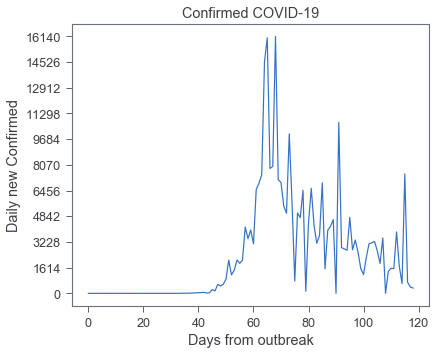

In [103]:
def graphProgression(countryDF,param,per_day=False): #TODO: x axis problem with dates, too messy
    """
    Graphs the progression in time of a given parameter regarding country info
    
    params:
        -countryDF (pandas.DataFrame): info about the country (see timeEvolution or worldTimeEvolution)
        -param (String): "Confirmed" -> confirmed cases of COVID-19 in country
                         "Deaths" -> deaths by COVID-19 in country
                         "Recovered" -> recovered patients in country 
        -per_day (bool): if True returns the graph by daily count, 
                         otherwise it will return total number

    """
    if not per_day:
        x = range(len(countryDF["Date"]))
        y = list(countryDF[param].astype(int))
        plt.ylabel(param)
    else:
        x = range(len(countryDF["Date"][1:]))
        y = list(countryDF[param].diff()[1:].astype(int))
        plt.ylabel("Daily new " + param)
    plt.plot(x,y)

    y_max = max(y)
    if y_max < 10:
        plt.yticks(range(0,max(y)+1,1))
    else:
        plt.yticks(range(0,max(y)+1,max(y)//10))
    plt.title("{} COVID-19".format(param))
    plt.xlabel("Days from outbreak")
    plt.show()

graphProgression(timeEvolution("Spain"),"Confirmed",per_day=True)

In [121]:
def realTimeEvolution(day=0):
    """
    Returns a Pandas DataFrame with infomration about the real time expansion of the virus.
    params:
        - day = possible values are {0 (today), 1 (yesterday), 2 (the day before)}
    returns:
        -pandas Dataframe
    """
    cols = ["Index","Country","Total Cases","New Cases","Total Deaths","New Deaths","Total Recovered","New Recovered","Active Cases","Serious, Critical","Tot Cases/1 M Pop","Deaths/1 M pop","Total Tests","Tests/ 1M pop", "Population",
            "X","X","X","X"]
    page = requests.get(WEB)
    soup = BeautifulSoup(page.content, 'html.parser')
    countryTable = soup.find_all('table')[0]
    rows = countryTable.find_all("tr")
    data =[]
    for row in rows:
        info = row.find_all("td")
        data.append([data.text.strip() if data.text.strip() != "" else "0" for data in info])
    df = pd.DataFrame(data,columns=cols)[9:]
    df.replace("\+|\-|,","",inplace=True,regex=True)
    for col in cols[2:]:
        df[col] = df[col].fillna(0)
        df[col] = df[col].replace("N/A",0)
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            continue
    
    df.drop(df[df["Country"]=='Total:'].index, axis=0, inplace=True)
    return df


def updateData():
    """
    Stores today's evolution data in csv format
    
    """
    df = realTimeEvolution()[["Country","Total Cases","Total Deaths","Total Recovered"]]
    df.columns=columns
    now = datetime.now()
    df.to_csv(DATA_DIR+now.strftime("%Y-%m-%d-%H-%M.csv"))
#updateData()
#realTimeEvolution()

,Index,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,"Serious, Critical",Tot Cases/1 M Pop,Deaths/1 M pop,Total Tests,Tests/ 1M pop,Population,X,X,X,X
9,1,USA,1923872,22089,110173,1031,707772,19102,1105927,17001,5815.0,333.00,19560112,59118,330864650,North America,172,3003,17
10,2,Brazil,612862,28882,33884,1337,266132,0,312846,8318,2885.0,159.00,930013,4378,212451006,South America,347,6270,228
11,3,Russia,441108,8831,5384,169,204623,8666,231101,2300,3023.0,37.00,11733051,80402,145930189,Europe,331,27104,12
12,4,Spain,287740,334,27133,5,0,0,0,617,6154.0,580.00,4063843,86921,46753542,Europe,162,1723,12
13,5,UK,281661,1805,39904,176,0,0,0,604,4151.0,588.00,5005565,73762,67860771,Europe,241,1701,14
14,6,Italy,234013,177,33689,88,161895,957,38429,338,3870.0,557.00,4049544,66970,60467811,Europe,258,1795,15
15,7,India,226713,9889,6363,275,108450,4379,111900,8944,164.0,5.00,4242718,3077,1379011457,Asia,6083,216723,325
16,8,Germany,184923,498,8736,37,167800,500,8387,600,2208.0,104.00,4348880,51917,83765266,Europe,453,9589,19
17,9,Peru,183198,4284,5031,137,76228,3909,101939,1005,5562.0,153.00,1135831,34485,32937238,South America,180,6547,29
18,10,Turkey,167410,988,4630,21,131778,926,31002,602,1987.0,55.00,2209583,26220,84272204,Asia,503,18201,38


#### 1.1.0. Dictionaries for resource mining

In [8]:
# Functions to initialize dictionaries for resource mining
def lcs(s1,s2): 
    """
    Returns the longest common substring between two strings.
    
    params:
        - s1 (String): first string
        - s2 (String): second string
    returns:
        - Longest Common Substring (LCS)
    """
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
            if m[x][y] > longest:
                longest = m[x][y]
                x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

def countryPred(country,possibleCountries):
    """
    Returns a prediction of a country name based on lcs similarity.
    
    params:
        - country (String): country name
        - possibleCountries (List): list with different ways to call the same country
    returns:
        - Prediction string
    """
    pred = sorted(possibleCountries,key=lambda x: len(lcs(country.replace(" ","").replace("China,","").replace("North","").replace(" China,",""),x.replace(" ","").replace("China,","").replace(" China,","").replace("North",""))),reverse=True)[0]
    return pred


def genDic(option):
    """
    Returns a dictionary of different ways to call a country specifying an option.
    
    params:
        - option (String): IMM for Immigration data countries or DEM for Demography data countries
    returns:
        - Dictionary of countries
    """
    realtime_countries = list(realTimeEvolution()['Country'].values)
    if option == "IMM":
        possibleCountries = MIG["Country of birth/nationality"].unique()
    elif option == "DEM":
        possibleCountries = [file.split(".csv")[0] for file in os.listdir(DEMO_DIR)]
    
    countries = [(country,countryPred(country,possibleCountries)) for country in realtime_countries]
    trash = ['Monaco', 'San Marino', 'Faeroe Islands', 'Andorra', 'Diamond Princess', 'Taiwan', 'Gibraltar', 'Vatican City', 'Liechtenstein']
    dic = {}
    for country,pred in countries:
        if country not in pred:
            if country == "USA":
                if option == "IMM":
                    pred = "United States" #change
                if option == "DEM":
                    pred = "United States of America"
            elif country == "UK":
                pred = "United Kingdom"
            elif country == "UAE":
                pred = "United Arab Emirates"
            elif country in trash:
                continue
            else:
                dic[country] = pred

        dic[country] = pred

    return dic

#NOTE: Take her to Alice in Wonderland Ballet

IMM_DICT = genDic("IMM")
DEM_DICT = genDic("DEM")

#### 1.2. Demography by country

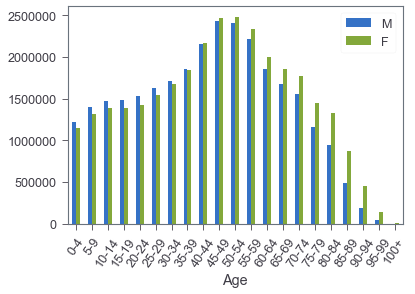

In [9]:

def saveDemography():
    """
    Mines https://www.populationpyramid.net and saves population pyramids 
    in csv files stored in the population directory
    """
    #TODO mine https://www.populationpyramid.net/<country>/2019/ , they have download by link, need to know country number, explore HTML + wget
    DEM = "https://www.populationpyramid.net/"
    html_page = requests.get(DEM)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    page_data = soup.find_all(class_='countryLink')
    l = []
    if not os.path.exists(DEMO_DIR):
        os.makedirs(DEMO_DIR)
    for country in page_data:
        d = {}
        aux = country.contents[0]
        if (aux == "Australia/New Zealand"):
            aux = "New Zealand"
        d['Country'] = aux
        d['ID'] = country['country']
        l.append(d)
        
    for country in l:
        c, ids = country.get("Country"), country.get("ID")
        CSV = "https://www.populationpyramid.net/api/pp/"+ids+"/2019?csv=true"
        r = requests.get(CSV)
        filename = c+".csv"
        file_path = os.path.join(DEMO_DIR, filename)
        if r.ok:
            print(filename + " : saving data to ... ", os.path.abspath(DEMO_DIR))
            with open(file_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024 * 8):
                    if chunk:
                        f.write(chunk)
                        f.flush()
                        os.fsync(f.fileno())
        else:  # HTTP status code 4XX/5XX
            print("Download failed: status code {}\n{}".format(r.status_code, r.text))
    

def getDemography(country_info):
    """
    Gets the population pyramid of a given country
    
    params:
        - country_info (string): name of the country (assuming notation)
    returns:
        pandas.DataFrame
    """
    country_info = DEM_DICT[country_info]
    file = country_info+".csv"
    df = pd.read_csv(DEMO_DIR + file)
    return df

def plotDemography(country_info):
    """
    Plots the demography pyramid of a country separeted by sex
    
    params:
        - country_info (string): name of the country (assuming notation)
    """
    df = getDemography(country_info)
    a = df.plot
    a.bar(x='Age',rot=55)

def eqCountry(country):
    """
    Returns the common string to name a country.
    
    params:
        - country (String): second name
    returns:
        - Common way to call the country
    """
    if country == 'Korea, Republic of':
        country = 'S. Korea'
    for k, v in DEM_DICT.items():
        if country in v:
            country = k
    return country
    
def inhabitantsCountry(country):
    """
    Returns the population of a country.
    
    params:
        - country (String): country
    returns:
        - Total sum of inhabitants per country
    """
    data = getDemography(eqCountry(country))
    return (data['M'] + data['F']).sum()


country_info="Italy"
plotDemography(country_info)


#### 1.3. Immigration flow information

In [10]:
def __immigration(c_from,c_to):
    """
    Gets information of incoming immigrants from a country to another in time.
    
    params:
        - c_from : country of departure 
        - c_to: country of arrival (assuming notation)
    returns:
        - pandas.DataFrame
    """
    c_to = IMM_DICT[c_to]
    cols = ["Year","Value"]
    df = MIG[(MIG["VAR"]=="B11") & (MIG["Country of birth/nationality"]==c_from) &((MIG["Country"]==c_to))][cols] 
    df.set_index("Year",inplace=True)
    return df

def immigrationTo(country):
    """
    Returns the immigration flow to a country by immigrant nationality
    
    params:
        -country: destination country (assuming notation)
    returns:
        pandas.DataFrame
    """
    l = []
    for c_from in MIG["Country of birth/nationality"].unique():
        if c_from == "Stateless" or c_from == "Total" or c_from == "Unknown":
            continue
        else:
            df = __immigration(c_from,country)
            if not df.empty and df.iloc[-1]["Value"] != 0:
                l.append([c_from,df.iloc[-1]["Value"]])
    ret = pd.DataFrame(l,columns=["Country","People"])
    ret.set_index("Country",inplace=True)
    return ret
            
immigrationTo("USA")

,People
Country,
Afghanistan,19538.0
Albania,5722.0
Algeria,2139.0
Andorra,2.0
Angola,209.0
...,...
Venezuela,11809.0
Viet Nam,38231.0
Yemen,6029.0


#### 1.4. Hospital Resources

##### 1.4.1. Hospital Beds

In [99]:
def hospitalBeds():
    """
    Returns a Pandas DataFrame with last information about the number of beds per country
    provided by OECD.
    
    returns:
        - Pandas DataFrame with OECD data filtered by last info in descending order
    """
    pd.set_option('display.max_rows', None)
    data = pd.read_csv("HOSPITAL_BEDS.csv")
    data = data.drop(columns=['SUBJECT', 'INDICATOR', 'FREQUENCY'])
    for code in data['LOCATION'].unique():
        data.replace({'LOCATION': code}, pc.countries.get(alpha_3=code).name, inplace=True)
    data = data.sort_values('TIME', ascending=False).groupby('LOCATION', sort=False).first().sort_values('Value', ascending=False).reset_index()
    return data

def bedsCountry(country):
    """
    Returns the specific number of beds per 1000 habitants of a country.
    
    params:
        - country (String): country
    returns:
        - Float number of beds per 1000 habitants
    """
    data = hospitalBeds()
    try:
        return float(data[data.LOCATION.eq(country)].Value.iloc[0])
    except:
        return None


def tableBedsCountry():
    """
    Returns a Pandas DataFrame with population and beds per country.
    
    returns:
        - Panda DataFrame
    """
    data = hospitalBeds()
    countries = data['LOCATION'].tolist()
    countries.remove('Turkey')
    dic = {}
    for c in countries:
        dic[c] = {}
        dic[c]['N. Habitants'] = inhabitantsCountry(c)
        dic[c]['Beds/1000 hab.'] = bedsCountry(c)
        dic[c]['N. Beds'] = bedsCountry(c)/1000*inhabitantsCountry(c)
    df = pd.DataFrame.from_dict(dic, orient='index')
    df.insert(1,"Country",[eqCountry(c) for c in df.index])
    df.set_index("Country",inplace=True)
    return df
#hospitalBeds()
#tableBedsCountry()
print(bedsCountry("Chile"))

2.11


##### 1.4.2. SARS-COV-2 Fatality Rates

In [48]:
def fatalityRate(option):
    """
    Mines https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/
    Note: 3.4% Mortality Rate estimate by the World Health Organization (WHO) as of March 3
    """
    FR = "https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/"
    html_page = requests.get(FR)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    page_age = soup.find_all('table')[0]
    page_sex = soup.find_all('table')[2]
    page_comorbidity = soup.find_all('table')[5]
    if option == 0:
        df = pd.read_html(str(page_age), header=0)[0]
        #df.drop('DEATH RATE confirmed cases', axis=1, inplace=True)
    elif option == 1:
        df = pd.read_html(str(page_sex), header=0)[0]
    elif option == 2:
        df = pd.read_html(str(page_comorbidity), header=0)[0]
        #print(df)
        df.drop('DEATH RATE confirmed cases', axis=1, inplace=True)
        df['DEATH RATE all cases'].replace('no fatalities', '0.0%', inplace=True)
    return df
fatalityRate(COM)
#fatalityRate(AGE)
#fatalityRate(SEX)

,PRE-EXISTING CONDITION,DEATH RATE all cases
0,Cardiovascular disease,10.5%
1,Diabetes,7.3%
2,Chronic respiratory disease,6.3%
3,Hypertension,6.0%
4,Cancer,5.6%
5,no pre-existing conditions,0.9%


#### 1.4.3. General Fatality Rates

In [51]:
def extractFR():
    """
    Mines https://www.who.int/nmh/countries/en/
    """
    FR_WHO = "https://www.who.int/nmh/countries/en/"
    html_page = requests.get(FR_WHO)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    page_data = soup.find_all(target='_new')
    if not os.path.exists(WHO_DIR):
        os.makedirs(WHO_DIR)
    for country in page_data:
        url = "https://www.who.int"+country.get('href').replace(" ", "")
        name = str(country.contents[0]).split(' [pdf 78kb]')[0]
        r = requests.get(url, allow_redirects=True, stream=True)
        filename = name+".pdf"
        file_path = os.path.join(WHO_DIR, filename)
        if r.ok:
            print(filename + " : saving data to ... ", os.path.abspath(WHO_DIR))
            with open(file_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024 * 8):
                    if chunk:
                        f.write(chunk)
                        f.flush()
                        os.fsync(f.fileno())
        else:  # HTTP status code 4XX/5XX
            print("Download failed: status code {}\n{}".format(r.status_code, r.text))
    

def getFRCountry(country):
    """
    Returns the country Fatality Rate comorbidity
    """
    try:
        filename = country+".pdf"
        file_path = os.path.join(WHO_DIR, filename)
        with open(file_path, 'rb') as f:
            text = PdfFileReader(f).getPage(0).extractText()
        x = text.split('% of the population   ')[1].split('CURRENT TOBACCO SMOKING')[0].split('  ')
        x = [i.replace("\n", "").strip() for i in x]
        x[4] = x[4].replace(x[4][3:], x[4][3:13]+"(Hypertension)")
        x.pop(2)
        x.pop(2)
        x = [i.split('%') for i in x]
        x = [i[::-1] for i in x]
        x = [x[i] for i in [0, 4, 3, 2, 1]]
        df = pd.DataFrame(x)
        df.columns = ['PRE-EXISTING CONDITION', 'DEATH RATE all cases']
        #df.loc[5] = ['no pre-existing conditions',math.nan] o eso o tomar solo 4 primeras
        return df
    except (FileNotFoundError, IOError):
        print("Wrong file or file path")

def peopleAtRisk(country):
    fr_country = list(map(float, getFRCountry(country)['DEATH RATE all cases'].tolist()))
    fr_coronavirus = []
    for i in fatalityRate(COM)['DEATH RATE all cases'].tolist():
        i = float(i.split('%')[0])
        fr_coronavirus.append(i)
    infected = timeEvolution(country)['Confirmed'].tolist()[-1]
    x = list(map(operator.mul, [i/100 for i in fr_country], [j/100 for j in fr_coronavirus[:5]]))
    aux =[i*infected for i in x]
    return int(sum([i*infected for i in x]))
peopleAtRisk('Spain')

19003

#### 1.4.4. Available Hospital Beds Estimation

In [72]:
def hospitalRatio():
    pd.set_option('display.max_rows', None)
    data = pd.read_csv("HFA.csv")
    data = data.drop(columns=['COUNTRY_GRP','SEX'])
    data.dropna(inplace=True)
    for code in data['COUNTRY'].unique():
        data.replace({'COUNTRY': code}, pc.countries.get(alpha_3=code).name, inplace=True)
    data = data.sort_values('YEAR', ascending=False).groupby('COUNTRY', sort=False).first().sort_values('VALUE', ascending=False).reset_index()
    return data

def HRCountry(country):
    data = hospitalRatio()
    data = data.drop(columns='YEAR')
    value = data.loc[data['COUNTRY'] == country]
    percent = float(value['VALUE'])/100
    n_o = (bedsCountry(country)/1000)*inhabitantsCountry(country)
    return percent*n_o

def availableHospitalBeds(country):
    try:
        n_o = (bedsCountry(country)/1000)*inhabitantsCountry(country)
        return int(n_o - (HRCountry(country) + peopleAtRisk(country)))
    except (NameError, TypeError):
        print("Country not found")
        return None

    
bedsCountry("Canada")

2.5

### 2 Mathematical models

#### 2.1 Models

0.9903118538789553
     Days        People
0       1  7.369358e+00
1       2  1.764557e+01
2       3  3.310148e+01
3       4  5.509195e+01
4       5  8.516955e+01
5       6  1.251197e+02
6       7  1.769869e+02
7       8  2.431015e+02
8       9  3.261081e+02
9      10  4.289958e+02
10     11  5.551307e+02
11     12  7.082910e+02
12     13  8.927034e+02
13     14  1.113083e+03
14     15  1.374674e+03
15     16  1.683295e+03
16     17  2.045385e+03
17     18  2.468053e+03
18     19  2.959128e+03
19     20  3.527214e+03
20     21  4.181746e+03
21     22  4.933049e+03
22     23  5.792393e+03
23     24  6.772061e+03
24     25  7.885409e+03
25     26  9.146929e+03
26     27  1.057231e+04
27     28  1.217851e+04
28     29  1.398381e+04
29     30  1.600787e+04
30     31  1.827180e+04
31     32  2.079821e+04
32     33  2.361123e+04
33     34  2.673658e+04
34     35  3.020158e+04
35     36  3.403521e+04
36     37  3.826802e+04
37     38  4.293222e+04
38     39  4.806160e+04
39     40  5.369145e+

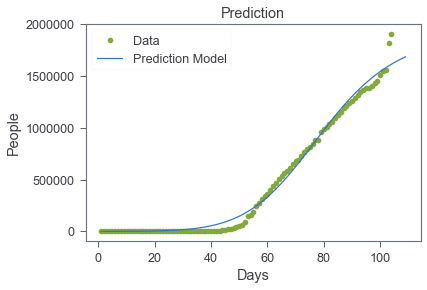

In [73]:


def expModel(x_data,a,b,d,f):
    """
    Logistic model f(x) = a / (b + f^(-x)*d)
    
    params:
        (a,b,d,f) : numbers for modelling
        x_data : numpy array with data
    
    returns:
        numpy array with vallues corresponding to the model predicition
    """
    return d*np.exp(a*x_data + b) + f
    #return a/(b+(f**-(np.array(x_data)**d)))

def logisticModel(x_data,a,b,d,f):
    return a/(b+(f**-(np.array(x_data)**d)))
    
def fit(func,x_data,y_data):
    """
    fits a function to given data
    
    params:
        -func (function): function to adjust
        -x_data (numpy array): x points
        -y_data (numpy array): y points
    """
    popt, pcov = curve_fit(func,x_data,y_data,maxfev = 10000, bounds=([0,0,-np.inf,0], [np.inf]*4))
    return lambda x: func(x,*popt)

def fromFirstCase(country_df,param):
    """
    Returns x and y values for data given a country from the first day when country had 10 or more cases
    
    params:
        -country_df (pandas.DataFrame): evolution of the country (see timeEvolution())
        -param (String): parameter ("Infected,Deaths,Recovered")
    """
    
    df = country_df[country_df[param] > 10]
    if df.empty:
        return None
    else:
        return np.array(range(1,df.shape[0]+1)),np.array(df[param])

def prediction(country,param,days,model,fromNow=False):
    """
    Return the prediction for a given number of day counting from now or the begining of significant cases
    
    params:
        - country (String): country
        - param (String): parameter ("Infected,Deaths,Recovered")
        - days (Int): number of days from now to predict
        - fromNow (Bool): consider from now (Default) or from the begining. 
    returns:
        days data, param data, pandas DataFrame with data desired
    """
    x_data,y_data = fromFirstCase(timeEvolution(country),param)
    adj = fit(model,x_data,y_data)
    if fromNow :
        x = range(len(x_data),len(x_data)+1+days)
    else:
        x = range(1,len(x_data)+1+days)
    
    y = adj(x)
    return x_data,y_data,pd.DataFrame([[day,people] for day,people in zip(x,y)],columns=["Days","People"])




def plotPrediction(x_data,y_data,df):
    """
    Plots the prediciton
    
    params:
        - x_data (numpy array): relevant data (days)
        - y_data (numpy array): relevant data (param)
        - df (pandas DataFrame): dataframe with prediction
    """
    x,y = df["Days"],df["People"]
    plt.plot(x_data,y_data,'go',label="Data")
    plt.plot(x,y,label="Prediction Model")
    plt.title("Prediction")
    plt.xlabel("Days") 
    plt.ylabel("People")
    plt.legend()


def modelR2(param,model):
    l = []
    for country in list(realTimeEvolution()['Country'].values):
        try:
            data = fromFirstCase(timeEvolution(country),param)
            if country == "Diamond Princess" or country == "Japan" or data == None or len(data[0]) < 2:
                continue
            else:
                x_data,y_data = data
                adj = fit(model,x_data,y_data)
                pred = adj(x_data)
                l.append(r2_score(y_data,pred))
        except:
            continue #country does not have more than 100 cases
    return np.mean(l)

def countryR2(country,param,model):
    data = fromFirstCase(timeEvolution(country),param)
    x_data,y_data = data
    adj = fit(model,x_data,y_data)
    pred = adj(x_data)
    return r2_score(y_data,pred)

print(countryR2("USA","Confirmed",logisticModel))
x_data,y_data,df = prediction("USA","Confirmed",5,logisticModel,fromNow=False)
print(df)
plotPrediction(x_data,y_data,df)

### 2.2. Stats

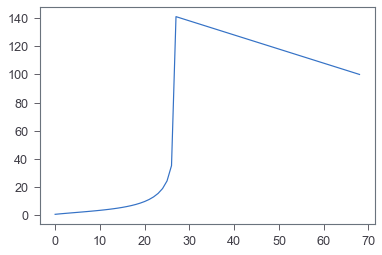

In [18]:
#NEED SOME REVIEW
def inverse(func,y,x1,x2,tol=0.001):
    assert x1 < x2
    mid = (x2 - x1)/2 
    if mid <= tol or func(x1 + mid) == y :
        return x1+mid
    elif y > func(x1+mid):
        return inverse(func,y,x1+mid,x2,tol)
    else:
        return inverse(func,y,x1,x1+mid,tol)


def t2(country,model):
    x_data,y_data = fromFirstCase(timeEvolution(country),"Deaths")
    adj = fit(model,x_data,y_data)
    t2_rates = []
    for x in x_data[1:]:
        inv = inverse(adj,2*adj(x),x_data[0],x_data[-1]+100)
        t2_rates.append((x,inv-x))
    return pd.DataFrame(t2_rates,columns=["Day (>100 cases)","T2"])

def plotT2(country,model=logisticModel):
    t2(country,model)["T2"].plot()

plotT2("Spain")
    

In [ ]:
####WORKING

"""def ageAffected(country_info):
    demography = getDemography(country_info)
    ageFatality = fatalityRate(AGE)
    data = []
    data.extend([[x]*2 if x != "80+ years old" else [x]*5 for x in ageFatality["AGE"]])
    data = sorted([item for sublist in data for item in sublist])
    demography["Age"] = data
    age_df = demography.groupby("Age").sum()
    return age_df

def populationAffectedByDemography(country,days,model):
    x_data,y_data,df = prediction(country,"Confirmed",days,model,fromNow=True)
    data = []
    infected = list(df["People"])[-1]
    ageFatality = fatalityRate(AGE)
    affected = ageAffected(country)
    l = []
    for age,row in affected.iterrows():
        try:
            rate = float(list(ageFatality[ageFatality["AGE"] == age]["Share of deaths"])[0].split("%")[0])
        except:
            rate = 0
        l.append((age,rate/100*row["M"]*infected/inhabitantsCountry(country)))
    return pd.DataFrame(l,columns=["Age","Deaths"])

ageAffected("Spain")
#populationAffectedByDemography("Spain",2,logisticModel)"""


### Risk of collapsing health system

In [122]:


def mapCollapseRisk(days):
    """
    Creates a folium Choropleth map that shows the risk of suffering a collapse in 
    the health system of each country in a given number of days.
    The darker the color the greater the risk in a Red-Purple color scale

    params:
        -days: the risk will be evaluated at this days from now

    returns:
        -Folium Choropleth map

    IMPORTANT: if a country has not provided the number of active cases or patients in
                critical condition, the country will appear with color white (No data).
    """
    df = realTimeEvolution(day=1)[["Country","Active Cases","Tests/ 1M pop","Population","Serious, Critical"]]
    L = []
    for index, row in df.iterrows():
        try:
            tests_1m = row["Tests/ 1M pop"]
            if tests_1m == 0:
                continue
            pop = row["Population"]
            crit = row["Serious, Critical"]
            cases = row["Active Cases"]
            if cases == 0:
                continue

            _,_,pred = prediction(row["Country"],"Confirmed",days,logisticModel,fromNow=True)
            estimated_critical = (crit/cases)*pred["People"].iloc[-1]

            if row["Country"] == "USA":
                L.append(["United States of America",np.log10((1+estimated_critical)/(bedsCountry("United States")*pop/1000))])
            elif row["Country"] == "UK":
                L.append(["United Kingdom",np.log10((1+estimated_critical)/(bedsCountry("United Kingdom")*pop/1000))])
            elif row["Country"] == "Russia":
                L.append(["Russia",np.log10((1+estimated_critical)/(bedsCountry("Russian Federation")*pop/1000))])
            else:
                L.append([row["Country"],np.log10((1+estimated_critical)/(bedsCountry(row["Country"])*pop/1000))])
        except:
            continue
    
    data = pd.DataFrame(L,columns=["Country","Danger"]) 
    bins = 8
    m = folium.Map(titles='cartodbpositron',location=[0,100], zoom_start=3)

    ch = folium.Choropleth(
        geo_data="world_countries.json",
        name='choropleth',
        data=data,
        columns=['Country', 'Danger'],
        key_on='properties.name',
        fill_color='RdPu',
        nan_fill_color='white',
        fill_opacity=0.7,
        line_opacity=0.4,
        bins = bins,
        legend_name='Danger of health system collapse'
    ).add_to(m)

    ch.geojson.add_child(
        folium.features.GeoJsonTooltip(['name'],labels=False)
    )

    folium.LayerControl().add_to(m)

    return m

mapCollapseRisk(10)

#### Did you miss a day?

In [102]:
def recoverData(file,days_from,out_name):
    """
    Stores a csv data file recovered from an html stored file 
    from https://www.worldometers.info/coronavirus/
    
    params:
        - file: stored .html file
        - days_from: can be 0 (date of storage), 1 (date before of storage), 2 (days before storage)
        - out_name: the output csv file will be stored in data/<out_name>.csv
    returns:
        None
    """
    with open(file, "r") as f:
        cols = ["Index","Country/Region","Total Cases","New Cases","Total Deaths","New Deaths","Total Recovered","Active Cases","Serious, Critical","Tot Cases/1 M Pop","Deaths/1 M pop","Total Tests","Tests/ 1M pop", "Population"]
        soup = BeautifulSoup(f.read(), 'html.parser')
        table = soup.find_all('table')[days_from]
        df =  pd.read_html(str(table),header=0)[0]
        df.columns = cols
        df.drop(df.tail(1).index, inplace=True)
        df.fillna(0,inplace=True)
        df.replace("\+|\-|,","",inplace=True,regex=True)
        for col in cols[2:]:
            df[col] = df[col].fillna(0)
            df[col] = df[col].replace("N/A",0)
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                continue
        df = df[["Country/Region","Total Cases","Total Deaths","Total Recovered"]]
        df.columns = columns
        df.to_csv(DATA_DIR+out_name+".csv")

#recoverData("prueba.html",2,"2020-06-02-23-59")